In [1]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
# Check if the module path is already in sys.path
if module_path not in sys.path:
    # Add the module path to sys.path
    sys.path.append(module_path)

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from ipywidgets import interact
from functools import partial
from src.utils import retain
%matplotlib inline

In [3]:
# define our quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
# verification
assert f(1) == 3*1**2 - 4*1 + 5
f(1)

4

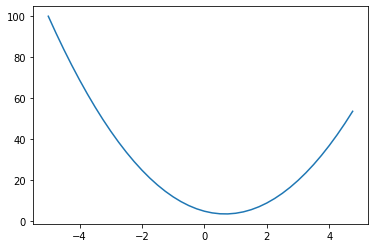

In [5]:
# plot the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## Partial derivative w.r.t single variable

**definition of being differentiable**::
$${\displaystyle L=\lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}}$$

In other words,  it is the limit as `h` goes to 0 of
$${\frac {f(x+h)-f(x)}{h}}$$

**RQ**: What it's saying is if you're at some point `x` 
that you're interested in, and if you slightly increase it by
small number `h`, how does the function respond and with what sensitivity does it respond. So what we really want to know is what is the slope at that point; does the function go up or does it go down? and by how much? 

So we can basically evaluate the derivative here numerically by taking a very small `h`. Of course the definition would ask us to take an `h` value of 0 but we're just going to pick a very small `h`, let's say     0.001, and let's say we're interested in point 3.0. 
We look at `f(x)` for `x=3` and see the value is `20`. so if we nudge `x` by a very small amount `h`, how will the function respond?

In [44]:
# check derivate at x = 3 --> nugding up leads to increase in value
h = 0.0001
x = 3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = 3 is {slope :.3f}")

The slope for f(x) at x = 3 is 14.000


In [45]:
# check derivate at x = -3 --> nugding up leads to decrease in value
h = 0.0001
x = -3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = -3 is {slope:.3f}")

The slope for f(x) at x = -3 is -22.000


In [46]:
# check derivate at x = 2/3 --> nugding up leads to no change in value 
h = 0.0001
x = 2/3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = 2/3 is {slope:.3f}")

The slope for f(x) at x = 2/3 is 0.000


In [47]:
# Double check result w/ pytorch
# pour differentes valeures de x
x = torch.tensor([3.0,-3.0,2/3], requires_grad=True)
# pour une fonction f donnee  
y = 3*x**2 - 4*x + 5

gradients = torch.autograd.grad(y, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x))
x1, x2, x3 = gradients[0]
print(f"The slope for f(x) at x = 3 is {x1:.3f}")
print(f"The slope for f(x) at x = -3 is {x2:.3f}")
print(f"The slope for f(x) at x = 2/3 is {x3:.3f}")

The slope for f(x) at x = 3 is 14.000
The slope for f(x) at x = -3 is -22.000
The slope for f(x) at x = 2/3 is 0.000


# Partial derivative w.r.t multiple variables

In order to evaluate this derivative we're going to get a bit hacky here:

 We're going to again have a very small value of `h` and then we're going to fix the inputs at some values that we're interested in (`a`,`b` and `c`).

After that we're going to be evaluating the the derivative of `d` with respect to `a`, `b` and `c` at that point. 

1. First we'll look at the derivative of `d` with respect to `a`; so we'll take `a`and we'll bump it by `h` and compare it to d2 which is the exact same function without the bump.

In [48]:
# our bump
h = 0.0001

# inputs at which we'll evaluate the derivative of d with respect to a, b and c.
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [49]:
# equation for d1 (adding h to a), so partial derivative of d with respect to a
d1 = a*b + c
a += h

# equation for d2 (without adding h to a)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to a
print(f"slope (gradient) with respect to a: {(d2-d1)/h:.3f}")

d1 : 4.0
d2 : 3.999699999999999
slope (gradient) with respect to a: -3.000


In [50]:
# equation for d1 (adding h to a), so partial derivative of d with respect to b
d1 = a*b + c
b += h

# equation for d2 (without adding h to b)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to b
print(f"slope (gradient) with respect to b: {(d2-d1)/h:.3f}")

d1 : 3.999699999999999
d2 : 3.99990001
slope (gradient) with respect to b: 2.000


In [51]:
# equation for d1 (adding h to a), so partial derivative of d with respect to c
d1 = a*b + c
c += h

# equation for d2 (without adding h to c)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to c
print(f"slope  (gradient) with respect to c : {(d2-d1)/h:.3f}")

d1 : 3.99990001
d2 : 4.00000001
slope  (gradient) with respect to c : 1.000


In [52]:
# Double check result w/ pytorch
a,b,c = torch.tensor([2.0,-3.0,10.0], requires_grad=True)
y = a*b + c
retain(a,b,c)
y.backward()
print(f"a.grad : {a.grad} || b.grad : {b.grad} || c.grad : {c.grad}")

a.grad : -3.0 || b.grad : 2.0 || c.grad : 1.0


However, we can't write out neural networks as mathematical expressions, they'd be monstrous, so instead what we're going to do is build a `Value Object`.

In [53]:
class Value:
    def __init__(self, data):
        self.data = data
    
    #  decide of the output string representation of data  
    # in human readable format 
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

In [54]:
a = Value(2.0)
a

Value(data=2.0)

In [55]:
# what if we want to add two Value objects?
a = Value(2.0)
b = Value(3.0)

try:
    c = a + b
    
except Exception as e:
    print(e)
    print(f"We have not implemented additions between two Value objects (yet!!)")

else:
    print(c)
    print("We have succesfully added two Value objects!!")

unsupported operand type(s) for +: 'Value' and 'Value'
We have not implemented additions between two Value objects (yet!!)


### Adding an __add__ method

In [56]:
class Value:
    def __init__(self, data):
        self.data = data
    
    #  decide of the output string representation of data   
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # define addition
    def __add__(self, other):
        # creer un nouvel object Value qui contient la somme des deux
        summation = Value(self.data + other.data)
        return summation

In [57]:
# Now that we have added the __add__ method, we can add two Value objects.
a = Value(2.0)
b = Value(3.0)

try:
    c = a+b
except Exception as e:
    print(e)
    print(f"We have not implemented additions between two Value objects (yet!!)")

else:
    print(c)
    print("We have succesfully added two Value objects!!")

Value(data=5.0)
We have succesfully added two Value objects!!


### Adding a __mult__ method

In [58]:
# define multiplication
def __mul__(self, other):
    mult = Value(self.data * other.data)
    return mult

In [59]:
# monkey patch it to our Value class
Value.__mul__ = __mul__

In [60]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a*b + c)
print((a.__mul__(b).__add__(c)))

Value(data=4.0)
Value(data=4.0)


# Putting the computational graph together

So now what we are missing is the connective tissue of this expression. We want to build a computational graph so we need to know and
keep pointers about what values produce what other values so here for example we are going to
introduce a new variable which we'll call children and by default it will be an empty tuple. Then we will keep a
slightly different variable in the class which we'll call underscore prev which will be the set of children.

In [42]:
class Value :

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        # tuple turned into set for efficiency
        self._prev = set(_children)
        # by default _op is the empty set for leaf nodes
        self._op = _op
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [43]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b
e = d + c

In [44]:
print(f"Children : {d._prev} || Operation applied : {d._op}")
print(f"Children : {e._prev} || Operation applied : {e._op}")

Children : {Value(data=-3.0), Value(data=2.0)} || Operation applied : *
Children : {Value(data=-6.0), Value(data=10.0)} || Operation applied : +


## Visualizing the code

In [45]:
from graphviz import Digraph

In [46]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # tuple turned into set for efficiency
        self._prev = set(_children)
        # by default _op is the empty set for leaf nodes
        self._op = _op
        # _label is the label associated with the node
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [47]:
def trace(root):
    # node: is the Value object being considered
    # edges : the two objects Value that created the node being considered
    nodes, edges = set(), set()
    def build(v):
        # prend initialement comme intrant le root node, puis
        # recursivement chaqune des child nodes
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # la recursion se passe ici
                build(child)
                
    # Finalement on construit tous les nodes et edges ici
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
   
    nodes, edges = trace(root)
    
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f }" % (n._label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [48]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b; e._label='e'
d = e + c; d._label ='d'
f = Value(-2.0, _label='f')
L = d * f; L._label = "L"

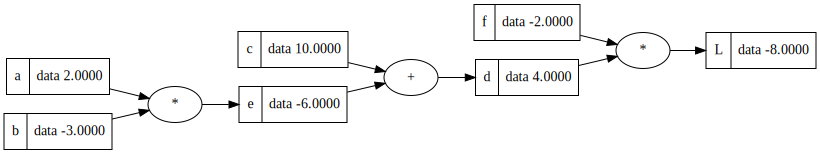

In [49]:
# visualize the result of a forward pass
draw_dot(L)

# Introducing backprop

In a neural network setting you'd be very interested in the derivative of  the loss function `L` with respect to the weights of a neural network. Here in our case we have the variables `a`, `b`, `c`, `d`, `e`, and `f` but they will eventually
represent the weights of a neural net and so we'll need to know how those weights are impacting the loss function. To do so we will need the derivative of the output with respect to `some` of its leaf nodes. Some of those leaf nodes will be the weights of the neural net, and the other leaf nodes will be the data itself but usually we will
not want or use the derivative of the loss function with respect to data because the data is fixed but the
weights will be iterated on using the gradient information.

So next we are going to create a variable inside the `Value` class that maintains the derivative of `L` with respect to that
value and we will call this variable `grad` so there's a `data` and there's a `self.grad`. Initially it will be zero (remember that a gradient of zero means it has no effect), so at initialization we're assuming that every value does not impact the
output (because if the gradient is zero, changing this variable is not changing the loss function)/

In [50]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
# Check if the module path is already in sys.path
if module_path not in sys.path:
    # Add the module path to sys.path
    sys.path.append(module_path)

In [51]:
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
%matplotlib inline

In [52]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # adding grad and setting it to 0. Ca va track le partial derivativ 
        # of the output with respect to the value of the node being considered
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [18]:
def trace(root):
    # node: is the Value object being considered
    # edges : the two objects Value that created the node being considered
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # la recursion se passe ici
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
   
    nodes, edges = trace(root)
    
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"node : {n._label} | value = {n.data} | gradient = {n.grad}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [54]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b; e._label='e'
d = e + c; d._label ='d'
f = Value(-2.0, _label='f')
L = d * f; L._label = "L"

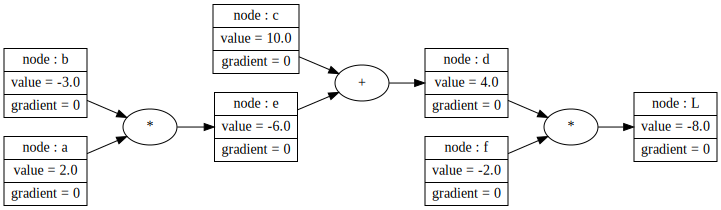

In [55]:
draw_dot(L)

In [56]:
def partial():
    """Calculating the derivative of L with respect to d"""
    h = 0.0001
    
    a = Value(2.0, _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c; d._label ='d'
    f = Value(-2.0, _label='f')
    L = d * f; L._label = "L"
    L1 = L.data
    
    # on ajoute `h` a notre Value `a`
    a = Value(2.0 , _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c ; d._label ='d'
    d.data +=h
    f = Value(-2.0, _label='f')
    L = d * f; L._label = "L"
    L2 = L.data
    
    # calcul de la derive partiel de L with respect to 'a'
    print((L2 - L1)/h)

In [57]:
partial()

-1.9999999999953388


We know that `L = d * f`, so what is `dL/dd?`? It is equal to `f`.

Here is the proof :

>Remember the equation for the derivative:
$$\frac{F(x+h)-F(x)}{h}$$

>So in our case:
$$\frac{dL}{dd}=\frac{(d+h)*f - (df)}{h}$$

>Which when expanded gives:
$$\frac{df + hf - df}{h} = \frac{ hf }{h} = f $$

So the derivative of `L` with respect to `d` is `f`. And we know by definition that `f` is a `Value object` with an associated scalar value (stored in the `.data` attribute) of `-2.0`. So `dL/dd = -2.0`.

Which is to say that the `gradient` of `d` with respect to `L` is `-2.0`.

We can apply the same process to find that the grad `gradient` of `f` with respect to `L` is `4`.

In [58]:
# store manualy the gradient
L.grad = 1
d.grad = -2
f.grad = 4

Now how do we obtain `dL/dc`? Lets break it down into two steps:
1. Find `dL/dd`
2. Find `dd/dc`
3. Apply the chain rule.

We already know `dL/dd` so now need `dd/dc`. We know that `d = c + e` so `dd/dc = 1`. We can reuse the demonstration from the previous cell to show `dd/dc = 1` for `d = c + e` 

>So in our case:

$$\frac{dd}{dc}=\frac{(c+h+e) - (c+e)}{h} = \frac{h}{h} = 1 $$

Now we just need to apply `the chain rule`, which definition can be found on wikipedia : 
The chain rule may also be expressed in Leibniz's notation. If a variable `z` depends on the variable `y`, which itself depends on the variable `x` (that is, `y` and `z` are dependent variables), then `z` depends on `x` as well, via the intermediate variable `y`. In this case, the chain rule is expressed as

$${\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}$$

So what this tells us that we need to multiply the result of 1. with the result of 2., which means multiply :
$$\frac{dL}{dc} = \frac{dL}{dd}*\frac{dd}{dc} $$

We calculated in `1.` that `dL/dd = f` and in `2.` that `dd/dc = 1`, so `dL/dc = 1*f = f`.  

Which is to say that the `gradient` of `c` with respect to `L` is `-2.0`.

We can apply the same process to find that the grad `gradient` of `e` with respect to `L` is `2.0`. 

**RQ:** les operations d'additions ne font que propager le gradient, c'est pourquoi `c.grad == e.grad == d.grad`, car `d` provient d'une operation d'addition

In [59]:
c.grad = -2.0
e.grad = -2.0

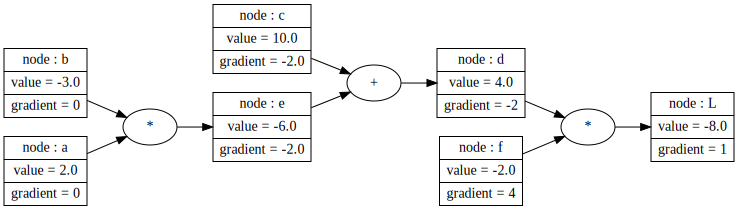

In [60]:
draw_dot(L)

Finalement pour trouver les gradient de `a` et `b` on prend la `derive locale` de `e` et on la multiplie par `de/db` pour obtenir `b.grad` et par `de/da` pour obtenir `a.grad`. (On reaplique recursivement la chaine rule a partir des derives locales).

1. `dL/de = -2.0`
2. `de/da` = `b` = -3.0 
3. `de/db` = `a` = 2.0 

> donc `dL/da` = `dL/de` * `de/da` = -2.0 * -3.0 = 6.0

> donc `dL/db` = `dL/de` * `de/db` = -2.0 * 2.0 = -4.0 

In [61]:
b.grad = -4.0
a.grad = 6.0

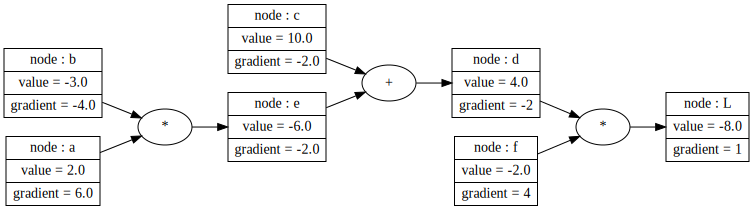

In [62]:
# la premiere backward pass est completee :)
draw_dot(L)

### Making our loss vary

In [ ]:
print(L.data)

In [66]:
# let's try to nudge our leaf nodes (a,b,c,f) to make our loss `L` go up.
# to do so we nudge our leaf nodes in the direction of the gradient (multiplied by a small number)
# because remember, the gradients we calculated are **local**; we dont want to overshoot
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

# run another forward pass after updating our gradients
e = a*b;
d = e + c; 
L = d * f; 

In [67]:
# We expected our Loss to go up, and it does.
print(L.data)

-7.215871776

# Backpropagating through a neuron
The last step we are missing is our activation function. Lets implement it and try it on a complete neuron example

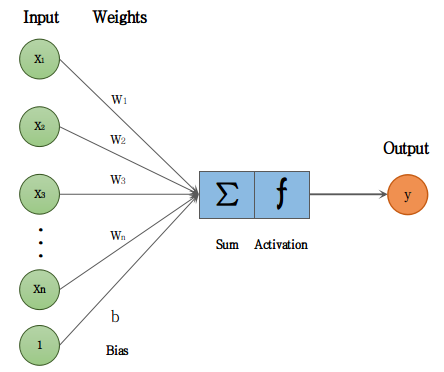

In [19]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

In [22]:
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.utils import draw_dot, trace
%matplotlib inline

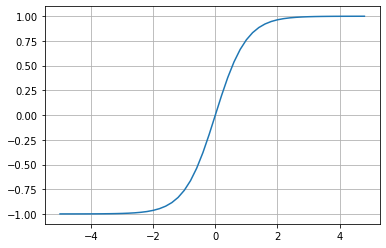

In [23]:
# activation function used to "squash" the neuron value.
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid()

So lets implement a tanh function, who's definition is as follows : 
\begin{equation}
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}
\end{equation}

In [24]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        # since the operation is on itself, and from itself, the _children tuple is only self.
        out = Value(t, _children=(self,), _op='tanh')
        
        return out

In [25]:
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.7, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# activation (we dont have one yet...)
output = n.tanh()

In [26]:
output.__dict__

{'data': 0.6043677771171636,
 'grad': 0,
 '_prev': {Value(data=0.7000000000000002)},
 '_op': 'tanh',
 '_label': ''}

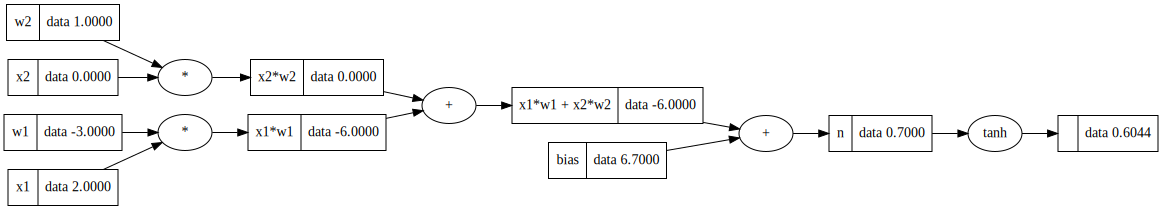

In [28]:
draw_dot(output)